# Model definition preamble

In [1]:
import sys; [sys.path.insert(0, i) for i in '../ ../PlexSim'.split()]
from matplotlib.pyplot import subplots, close
close('all')
from matplotlib import style, rcParams; 
style.use('seaborn-poster')
style.use('dark_background')
rcParams['figure.figsize'] = (5,5)

from plexsim.models import *
from Utils.plotting import addGraphPretty
from Toolbox import infcy
import numpy as np
%matplotlib widget
# define model
# g  = nx.path_graph(2, nx.DiGraph())
# g.add_edge(0, 1, weight = .1)
g = nx.star_graph(5)
# g = nx.grid_graph([8, 8])
# g.add_edge(1,1)
settings = dict(graph = g,\
                updateType = 'async',\
                agentStates = np.arange(2).tolist(),\
#                 sampleSize = 1,\
               nudgeType = "constant",\
               t = 1,\
               )

rules = nx.DiGraph()
rules.add_edge(0, 1)
rules.add_edge(1,1, weight = 0)
rules.add_edge(1, 2)
m = Potts(\
          rules = rules,\
          **settings)
# get snapshots
temps = np.geomspace(.01, 5, 50)
match = .5 # magnetize at this level
mag, sus = m.magnetize(temps = temps, n = 10000, \
                               match = match)

spawning threads
Magnetizing temperatures


0% [##############################] 100% | ETA: 00:00:000% [############################# ] 100% | ETA: 00:00:000% [#########################     ] 100% | ETA: 00:00:000% [##########################    ] 100% | ETA: 00:00:000% [#########                     ] 100% | ETA: 00:00:01

Optimization terminated successfully.
         Current function value: 0.118861
         Iterations: 22
         Function evaluations: 56
Sigmoid fit params [  4.14545248   3.92939104 -32.79117501   0.61886133]
At T=[2.015]



Total time elapsed: 00:00:01
/home/casper/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

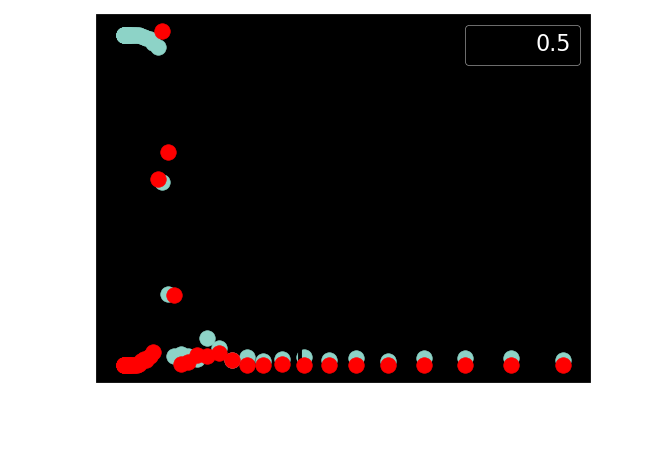

In [3]:

fig, ax = subplots()

tax = ax.twinx()
tax.scatter(temps, sus, color = "red")
ax.set_xlabel("T")
tax.set_ylabel(r"$\chi$")
ax.set_ylabel("<M>")
ax.scatter(temps, mag)

ax.axvline(m.t, \
           linestyle = 'dashed',\
           color = 'k', \
           label = match,\
           )
ax.legend()
fig.show()


In [3]:
#sim params

sim = dict(
    nTrials = 5,\
    nSamples = 10000,
    repeats  = 1000,
    deltas   = 10,
    reverse  = 1,
    center   = 0,
#     nudgeSizes = np.array([.01, .5, 2])
    nudgeSizes  = np.array([0.05, .1])
)
# infcy methods not working yet


nudge_impacts = infcy.doTrial(m, **sim)

0% [#         ] 100% | ETA: 00:00:01<ipython-input-3-1921e193d7af>:16: RuntimeWarning: divide by zero encountered in log2
  nudge_impacts = infcy.doTrial(m, **sim)


Starting trials


<ipython-input-3-1921e193d7af>:16: RuntimeWarning: invalid value encountered in multiply
  nudge_impacts = infcy.doTrial(m, **sim)
<ipython-input-3-1921e193d7af>:16: RuntimeWarning: divide by zero encountered in log
  nudge_impacts = infcy.doTrial(m, **sim)
<ipython-input-3-1921e193d7af>:16: RuntimeWarning: invalid value encountered in subtract
  nudge_impacts = infcy.doTrial(m, **sim)
0% [##########] 100% | ETA: 00:00:00
Total time elapsed: 00:02:09


## Nudging nodes

In [4]:
np.seterr('ignore')
# single nudges for now
from Utils.stats import KL # kl-divergence
from Utils.stats import JS
from tqdm.notebook import tqdm
from scipy.stats import sem
from copy import deepcopy

# show results
import matplotlib.pyplot as plt
def tmp_plot(nudge_impacts: dict) -> None:
    fig, ax = subplots(1, len(nudge_impacts), figsize = (5,4), \
                      sharey = 'all')
    fig.subplots_adjust(wspace = 0)
    color = plt.cm.tab20(range(m.nNodes))
    for axi, (nudge, data) in zip(ax.flat, \
                                 nudge_impacts.items() ):
        tmp = []
        data = {k : v for k, v in data.items() if k != 'control'}
        for node, trials in data.items():
            tmp_ = [trial.mean() for trial in trials]
            tmp_ = (np.mean(tmp_), 1 * sem(tmp_))
            tmp.append(tmp_)
        axi.bar(data.keys(), [i[0] for i in tmp], color = color)
        axi.errorbar(data.keys(), [i[0] for i in tmp],[i[1] for i in tmp],\
                   linestyle = 'none', color = 'w',\
                   capthick = 3)
        axi.tick_params('y', labelsize = 8, pad = 0)
        axi.set(title = f"$\eta$={nudge}")
    
    inax = axi.inset_axes((.6, .35, .7, .7))
    mainax = fig.add_subplot(111, frameon = 0, xticks = [], yticks = [])
    mainax.set(ylabel = dict(ylabel = 'KL-divergence \n(nudged vs control)',\
                            fontsize = 10, labelpad = 30))
    addGraphPretty(m.graph, ax = inax, circle = dict(radius = .4), annotate = dict(fontsize = 30))
#     inax.axis('off')
    inax.set(xticks = [], yticks = [])
    fig.suptitle(f'kNudges = {m.kNudges}', fontsize = 23, \
                 y = 1.03,\
                )
    fig.show()
    return fig

fig = tmp_plot(nudge_impacts)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Using circular_layout


Nudging works by picking a random edge with probabililty `nudgeSize`. All the edge weights in the system are set to 1. The parameter `kNudges` modifies the nudged edge with a double value what its assigned to. 

Above I simulate two differen situations. 
- `kNudges` = 1 corresponds to the situation where the edge weight is not edited, just the input from that edge is uniform over the possible states
- `kNudges` = 10000. Strong nudges. Whatever the node is modified too, it will carry a lot of weight. This would correspond more to a 'overwhelming' nudge. 

In [7]:
tmp = []
plt.close('all')
for k, v in nudge_impacts.items():
    for kk in v['control']:
        tmp.append(kk['mi'])
tmp = np.array(tmp)

colors = plt.cm.tab20(range(m.nNodes))


from scipy.stats import sem
s = sem(tmp, axis = 0).T
mu = tmp.mean(0).T


xr = np.arange(mu.shape[1])[::-1]*-1
fig, ax = plt.subplots()
for c, mm, ss in zip(colors, mu, s):
    ax.errorbar(xr, mm, ss, color = c)
ax.set_ylabel('$I(s_i^{t_0 + t}; S^{t_0 + t})$')
ax.set_xlabel('t')
fig.savefig('mi_time.png', transparent = 1)
fig.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
import os
os.system('jupyter nbconvert --to html nudges_drafts.ipynb')

0